<a href="https://colab.research.google.com/github/Ilvecoding0912/Robotic-3D-Detection-In-Surgery/blob/main/samples/DETR_Endovis_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch


In [60]:
!git clone https://github.com/facebookresearch/detr.git
%cd detr

fatal: destination path 'detr' already exists and is not an empty directory.
/content/detr/detr


Download pre-trained model

In [62]:
import gdown

# download model
url = 'https://drive.google.com/uc?id=1S59Aovb4dNOjsu_YdDLxz5wzpxwzww7p'
output = 'eval.zip'
gdown.download(url, output, quiet=True)

!unzip -q eval.zip

replace eval_0049.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
model = torch.load('eval_0049.pth', map_location=torch.device('cpu'))
model.eval()

Download image from Endovis dataset

In [37]:
url = 'https://drive.google.com/uc?id=1ycUjt29WI4VjK6grZnQXYdzdEuMhpqNA'
gdown.download(url, 'raw_img.jpg', quiet=True)

'raw_img.jpg'

In [ ]:
from PIL import Image
raw_img = Image.open('raw_img.jpg')
raw_img

Do transformation for the image

In [45]:

import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [48]:
# mean-std normalize the input image (batch-size: 1)
img = transform(raw_img).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.3+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], raw_img.size)

Visualize result

Save results:
Save the result image res.png


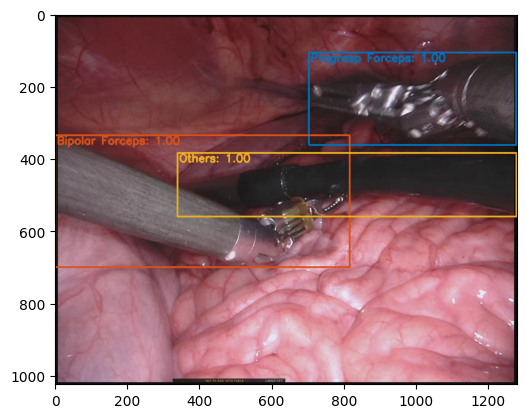

In [67]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = ('Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver', 'Vessel Sealer',
            'Grasping Retractor', 'Monopolar Curved Scissors', 'Others')

def plot_results(pil_img, prob, boxes):

    print('Save results:')
    img = np.array(pil_img)
    img = (img - img.min()) / (img.max()-img.min())
    font = cv2.FONT_HERSHEY_SIMPLEX

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS):
        top_corner, down_corner = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        cv2.rectangle(img, top_corner, down_corner, color=c, thickness=4)

        cl = p.argmax()
        text = f'{CLASSES[cl-1]}: {p[cl]:0.2f}'
        cv2.putText(img,str(text),(top_corner[0]+5, top_corner[1]+25), font, 1,c,4,cv2.LINE_AA)

    plt.imshow(img)
    plt.imsave(os.path.join('res.png'), img)
    print(f'Save the result image res.png')
    plt.show()

plot_results(raw_img, probas[keep], bboxes_scaled)